In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
train_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=False, transform=transforms.ToTensor(), download=True)

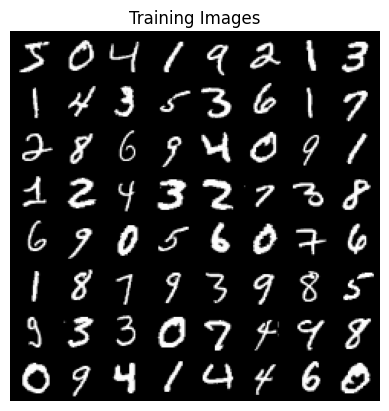

In [4]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = F.sigmoid(self.fc3(z))
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

        return x_hat

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

## latent_dim이 작아지거나 커지면 어떻게 될까??

- latent_dim이 작아지면 잠재 공간에 인코딩할 수 있는 정보의 양이 줄어 원본 데이터의 중요한 특성들이 충분히 표현되지 못할 수 있으며, 결과적으로 디코더가 원본 데이터를 재구성하는 데 어려움을 겪게된다.
- latent_dim이 커지면 더 많은 정보가 잠재 공간에 저장될 수 있다. 즉, 원본 데이터의 특징을 더 잘 보존하게 되어 디코더가 원본 데이터와 유사한 데이터를 재구성하는 데 유리하다.
- 단, 압축 효과가 줄어들어 오토인코더가 단순히 입력 데이터를 거의 그대로 통과시키는 현상이 발생할 수 있고, 이로 인해 오토인코더의 목적(데이터의 주요 특징을 추출하고 노이즈를 제거하는 것)이 약화될 수 있다.

In [7]:
epochs = 10
batch_size = 100
learning_rate = 0.001
latent_dim = 20

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 복원 태스크에 왜 MSE 손실 함수를 사용하는지 생각해보기
복원 태스크(reconstruction task)에서 MSE(Mean Squared Error) 손실 함수를 사용하는 이유는 다음과 같습니다:

오차의 크기를 직접적으로 측정: MSE는 예측값과 실제값 간의 차이를 제곱하여 평균을 구하는 방식으로, 이 차이를 직접적으로 측정합니다. 제곱된 값이기 때문에, 예측값이 실제값과 얼마나 다른지에 대한 크기를 잘 반영할 수 있습니다. 오차가 클수록 그 영향이 크게 반영되므로 모델이 작은 오차를 무시하지 않고, 전반적으로 정확한 복원을 할 수 있도록 합니다.

연속적인 출력에 적합: 복원 태스크에서 목표는 연속적인 데이터를 가능한 한 원본에 가깝게 재구성하는 것입니다. MSE는 이러한 연속적인 출력의 경우에 잘 작동하며, 각 픽셀 또는 데이터 포인트의 차이를 제곱하여 전체적으로 작은 오차를 얻는 방향으로 학습됩니다.

평균화된 오류 최소화: MSE는 모든 오차를 평균화하므로, 전체 데이터에 대해 전반적인 복원 성능을 최적화하는 데 유리합니다. 이는 특정 데이터 포인트에서의 오차보다, 전체적인 오차의 크기를 최소화하는 데 중점을 둡니다.

## binary_cross_entropy 손실 함수를 사용하면 어떻게 동작할 지 생각해보기
Binary Cross Entropy (BCE) 손실 함수를 사용하면 복원 태스크에서 다음과 같은 동작을 예상할 수 있습니다:

이진 분류 문제로 간주: BCE는 주로 이진 분류(binary classification) 문제에서 사용됩니다. 복원 태스크에서 BCE를 사용한다는 것은 각 출력 값이 0 또는 1로 이진화된다는 것을 의미합니다. 즉, 모델은 각 데이터 포인트가 0 또는 1 중 어느 하나의 값으로 나올 확률을 예측하게 됩니다.

픽셀 단위의 이진 결정: 예를 들어 이미지 복원에서 BCE를 사용하면, 각 픽셀을 0 또는 1로 재구성하려 할 것입니다. 이는 복원 태스크에서 우리가 일반적으로 원하는 연속적인 값 대신 이진화된 이미지를 생성하게 될 가능성이 큽니다. 이러한 경우 결과적으로 세밀한 복원이 어려워질 수 있습니다.

노이즈나 작은 변화에 민감: BCE는 MSE보다 노이즈나 작은 변화에 민감할 수 있습니다. 작은 차이도 큰 손실을 초래할 수 있기 때문에, 모델이 극단적인 이진 출력으로 수렴하거나 불안정한 학습을 겪을 수 있습니다.

특정 태스크에 적합할 수 있음: 만약 복원 태스크가 실제로 이진 출력이 필요한 경우, 예를 들어 흑백 이미지 복원이나 이진화된 데이터를 복원하는 경우라면, BCE 손실 함수가 적절하게 동작할 수 있습니다. 하지만 대부분의 연속적인 데이터 복원에는 적합하지 않을 것입니다.

In [8]:
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

recon_loss = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(params=list(autoencoder.parameters()), lr=learning_rate)

## train_epoch_loss /= train_size로 왜 나누어 주는지 생각해보기
train_epoch_loss /= train_size 코드는 에포크 동안 계산된 평균 손실을 구하기 위해 사용됩니다. 이 코드에서 train_epoch_loss는 전체 미니배치에 대한 손실의 합을 의미합니다. train_size는 그동안 학습한 전체 샘플의 개수를 나타냅니다. 이 둘을 나누어 줌으로써, 전체 에포크 동안의 평균 손실 값을 계산하게 됩니다.

손실 값은 각 미니배치에 대해 계산되므로, 에포크 전체에서 평균 손실을 구하려면 전체 손실의 합을 학습한 샘플 수로 나누어 주어야 합니다. 이렇게 하면 각 에포크마다 손실 값이 미니배치 크기와 관계없이 일관되게 측정될 수 있어, 모델의 학습 상태를 더 정확하게 평가할 수 있습니다.

## train_size를 더해주는 것과 len(train_loader.dataset)의 차이점 생각해보기
train_size를 더해주는 것은 각 배치에서 label.size(0)을 더하는 방식으로 현재 에포크에서 학습된 샘플 수를 추적합니다. 만약 train_loader에서 샘플을 불균형하게 가져오거나, 일부 배치가 누락될 경우에도 실제 학습된 샘플 수를 정확히 반영합니다.

len(train_loader.dataset)은 train_loader에 포함된 전체 데이터셋의 크기를 의미합니다. 이는 데이터셋의 전체 크기를 고정적으로 반환하므로, 데이터 로딩 중에 샘플이 누락되거나 일부 데이터가 반복되지 않는다면 실제 학습에 사용된 샘플 수와 차이가 있을 수 있습니다.

In [9]:
history = dict(train_loss=[], valid_loss=[])

print(f"Training start with {epochs} epochs.")
for epoch in range(1, 1 + epochs):
    
    train_size = 0
    train_epoch_loss = 0
    autoencoder.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)

        train_size += label.size(0)
        latent = autoencoder.encode(image)
        reconstruction_image = autoencoder.decode(latent)

        optimizer.zero_grad()
        train_loss = recon_loss(image, reconstruction_image)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss

    test_size = 0
    test_epoch_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent = autoencoder.encode(image)
            reconstruction_image = autoencoder.decode(latent)

            test_loss = recon_loss(image, reconstruction_image)
            test_epoch_loss += test_loss

    train_epoch_loss /= train_size
    test_epoch_loss /= test_size

    history["train_loss"].append(train_epoch_loss.item())
    history["valid_loss"].append(test_epoch_loss.item())

    print(f"[{epoch:02d}/{epochs:02d}]"
        + f"Train MSE Loss = {train_epoch_loss:.4f}, "
        + f"Valid MSE Loss = {test_epoch_loss:.4f}")

Training start with 10 epochs.
[01/10]Train MSE Loss = 36.7751, Valid MSE Loss = 20.5756
[02/10]Train MSE Loss = 17.0971, Valid MSE Loss = 14.2268
[03/10]Train MSE Loss = 13.0682, Valid MSE Loss = 11.6376
[04/10]Train MSE Loss = 11.1524, Valid MSE Loss = 10.2235
[05/10]Train MSE Loss = 9.9494, Valid MSE Loss = 9.2708
[06/10]Train MSE Loss = 9.0709, Valid MSE Loss = 8.6190
[07/10]Train MSE Loss = 8.5284, Valid MSE Loss = 8.2122
[08/10]Train MSE Loss = 8.1466, Valid MSE Loss = 7.9224
[09/10]Train MSE Loss = 7.8414, Valid MSE Loss = 7.7127
[10/10]Train MSE Loss = 7.5978, Valid MSE Loss = 7.4870


In [10]:
# 저장된 손실 함수를 시각화합니다.
def visualize_loss(epochs, train_loss, valid_loss):
    # x축 계산
    x_len = np.arange(epochs)

    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    # 그래프에 대한 레이블 정보를 우측 상단에 출력합니다.
    plt.legend(loc='upper right')
    plt.grid()
    # x축과 y축에 대한 레이블을 설정합니다.
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

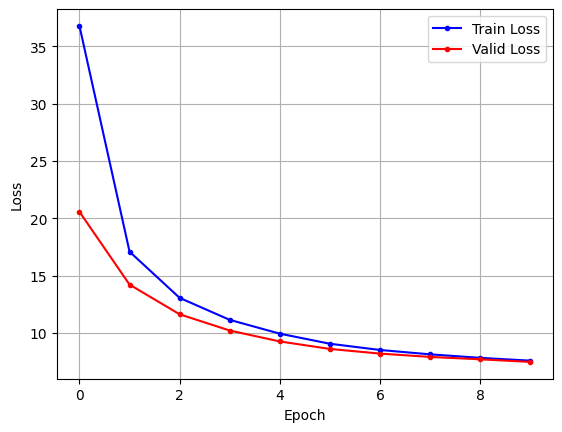

In [11]:
visualize_loss(epochs, history["train_loss"], history["valid_loss"])

In [12]:
select = 0
autoencoder.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue
        else:
            test_image, test_label = batch
            test_image = test_image.to(device)
            test_image = test_image.view(batch_size, 1 * 28 * 28)

            z = autoencoder.encode(test_image)
            reconstruction = autoencoder.decode(z)
            break

데이터 배치의 첫 번째 이미지입니다.


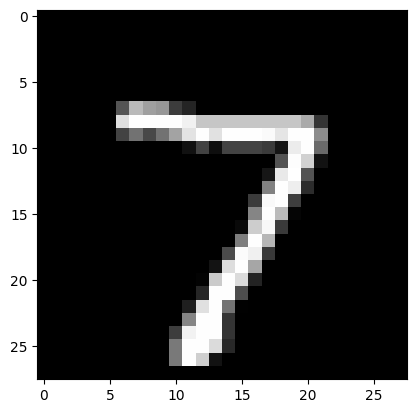

복원된 이미지입니다.


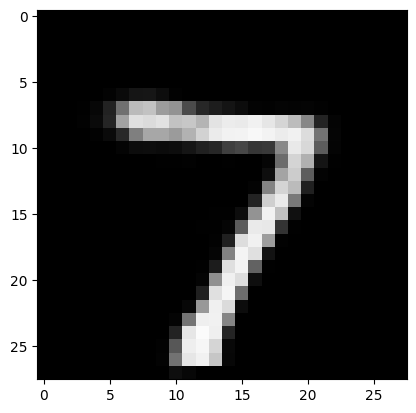

In [13]:
print("데이터 배치의 첫 번째 이미지입니다.")
plt.imshow(utils.make_grid(test_image[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

데이터 배치 이미지입니다.


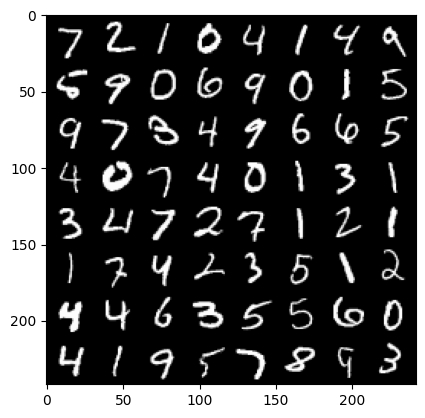

복원된 이미지입니다.


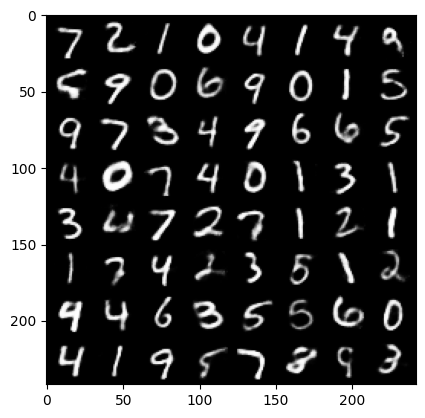

In [14]:
print("데이터 배치 이미지입니다.")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[:64].cpu()[:64].view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

In [15]:
from sklearn.manifold import TSNE

test_labels = []
test_latents = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch

        test_image = test_image.to(device)
        test_image = test_image.view(batch_size, 784)

        z = autoencoder.encode(test_image)
        test_latents.append(z)
        test_labels.append(test_label)

test_latents = torch.cat(test_latents).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

tsne = TSNE(n_components=2).fit_transform(test_latents)

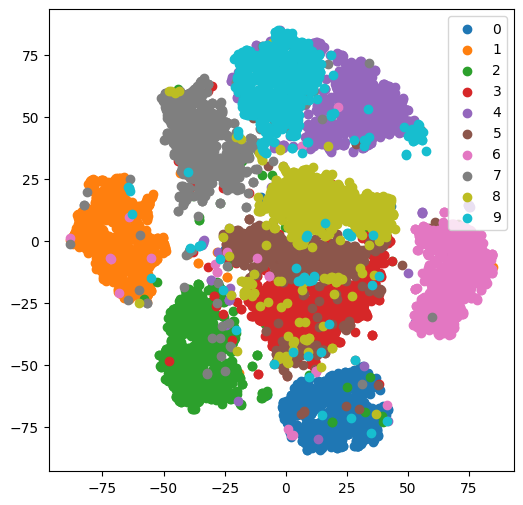

In [16]:
plt.figure(figsize=(6, 6))

target_ids = range(10)
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [17]:
test_images = []
test_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch
        test_image = test_image.view(batch_size, 784)

        test_images.append(test_image)
        test_labels.append(test_label)

test_images = torch.cat(test_images).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

tsne = TSNE(n_components=2).fit_transform(test_images)

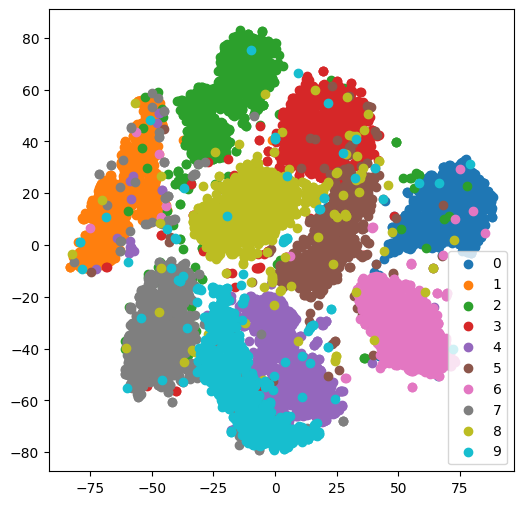

In [18]:
target_ids = range(10)

plt.figure(figsize=(6, 6))
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()